In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train_full = train_df.drop('smoking', axis=1)
y_train_full = train_df['smoking']
X_test_final = test_df.copy()

print(f"Train: {train_df.shape}, Test: {test_df.shape}")

Train: (38984, 23), Test: (16708, 22)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_full
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (31187, 22), Val: (7797, 22)


In [4]:
def create_health_features(df):
    df_new = df.copy()
    df_new['BMI'] = df_new['weight(kg)'] / ((df_new['height(cm)'] / 100) ** 2)
    df_new['waist_height_ratio'] = df_new['waist(cm)'] / df_new['height(cm)']
    df_new['total_hdl_ratio'] = df_new['Cholesterol'] / (df_new['HDL'] + 1)
    df_new['ldl_hdl_ratio'] = df_new['LDL'] / (df_new['HDL'] + 1)
    df_new['ast_alt_ratio'] = df_new['AST'] / (df_new['ALT'] + 1)
    df_new['pulse_pressure'] = df_new['systolic'] - df_new['relaxation']
    df_new['eyesight_avg'] = (df_new['eyesight(left)'] + df_new['eyesight(right)']) / 2
    df_new['eyesight_diff'] = np.abs(df_new['eyesight(left)'] - df_new['eyesight(right)'])
    df_new['hearing_avg'] = (df_new['hearing(left)'] + df_new['hearing(right)']) / 2
    df_new['age_squared'] = df_new['age'] ** 2
    df_new['age_cubed'] = df_new['age'] ** 3
    return df_new

X_train_eng = create_health_features(X_train)
X_val_eng = create_health_features(X_val)
X_train_full_eng = create_health_features(X_train_full)
X_test_eng = create_health_features(X_test_final)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_val_scaled = scaler.transform(X_val_eng)
X_train_full_scaled = scaler.transform(X_train_full_eng)
X_test_scaled = scaler.transform(X_test_eng)

print(f"Total features after engineering: {X_train_eng.shape[1]}")

Total features after engineering: 33


In [5]:
def get_gmm_predictions(model, X, X_train_for_mapping, y_train_for_mapping):
    # 1. Predict cluster labels for training data
    train_clusters = model.predict(X_train_for_mapping)
    
    # 2. Map each cluster to the most frequent class label in that cluster
    cluster_to_class = {}
    for cluster in range(model.n_components):
        indices = np.where(train_clusters == cluster)[0]
        if len(indices) == 0:
            cluster_to_class[cluster] = 0 # Default/Fallback
        else:
            # Find majority class
            true_labels = y_train_for_mapping.iloc[indices]
            mode = true_labels.mode()
            if not mode.empty:
                cluster_to_class[cluster] = mode[0]
            else:
                cluster_to_class[cluster] = 0
    
    # 3. Predict clusters for new data X
    test_clusters = model.predict(X)
    
    # 4. Map clusters to class labels
    y_pred = np.array([cluster_to_class[c] for c in test_clusters])
    return y_pred, cluster_to_class

In [6]:
# Baseline Model (Default Hyperparameters)
# Note: Default GMM has 1 component, which is trivial. Let's start with n_components=2 (classes)
print("Training Baseline GMM (n_components=2)...")
baseline_model = GaussianMixture(n_components=2, random_state=RANDOM_STATE)
baseline_model.fit(X_train_scaled)

# Evaluate using mapping
y_pred_baseline, _ = get_gmm_predictions(baseline_model, X_val_scaled, X_train_scaled, y_train)

print("Baseline Validation Metrics:")
print(classification_report(y_val, y_pred_baseline))
print(f"Baseline Accuracy: {accuracy_score(y_val, y_pred_baseline):.4f}")

Training Baseline GMM (n_components=2)...
Baseline Validation Metrics:
              precision    recall  f1-score   support

           0       0.63      1.00      0.78      4933
           1       0.00      0.00      0.00      2864

    accuracy                           0.63      7797
   macro avg       0.32      0.50      0.39      7797
weighted avg       0.40      0.63      0.49      7797

Baseline Accuracy: 0.6327


In [7]:
def objective(trial):
    n_components = trial.suggest_int('n_components', 2, 20)
    covariance_type = trial.suggest_categorical('covariance_type', ['full', 'tied', 'diag', 'spherical'])
    reg_covar = trial.suggest_float('reg_covar', 1e-6, 1e-3, log=True)
    
    model = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        reg_covar=reg_covar,
        random_state=RANDOM_STATE,
        max_iter=100
    )
    
    model.fit(X_train_scaled)
    
    # Evaluate using the cluster-mapping strategy
    y_pred, _ = get_gmm_predictions(model, X_val_scaled, X_train_scaled, y_train)
    
    return f1_score(y_val, y_pred, average='weighted') # Maximizing Weighted F1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, timeout=600, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best F1:", study.best_value)

[I 2025-12-08 20:35:39,238] A new study created in memory with name: no-name-991b59d7-b09f-403f-b565-3d806ab8028e


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-12-08 20:35:53,324] Trial 0 finished with value: 0.6443260318673607 and parameters: {'n_components': 11, 'covariance_type': 'full', 'reg_covar': 1.1152078607866895e-06}. Best is trial 0 with value: 0.6443260318673607.
[I 2025-12-08 20:35:58,922] Trial 1 finished with value: 0.6950047866877472 and parameters: {'n_components': 11, 'covariance_type': 'tied', 'reg_covar': 3.2594462482998526e-05}. Best is trial 1 with value: 0.6950047866877472.
[I 2025-12-08 20:35:59,240] Trial 2 finished with value: 0.6379651109116152 and parameters: {'n_components': 3, 'covariance_type': 'spherical', 'reg_covar': 0.0001226437556980051}. Best is trial 1 with value: 0.6950047866877472.
[I 2025-12-08 20:37:17,563] Trial 3 finished with value: 0.6696202528192396 and parameters: {'n_components': 20, 'covariance_type': 'full', 'reg_covar': 7.778315091651339e-05}. Best is trial 1 with value: 0.6950047866877472.
[I 2025-12-08 20:37:51,670] Trial 4 finished with value: 0.6562509914070204 and parameters: {'

In [8]:
best_params = study.best_params
final_model = GaussianMixture(
    **best_params,
    random_state=RANDOM_STATE,
    max_iter=300
)

# Fit on full training data (unsupervised)
final_model.fit(X_train_full_scaled)

,n_components,11
,covariance_type,'tied'
,tol,0.001
,reg_covar,3.2594462482998526e-05
,max_iter,300
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


Final GMM Evaluation (Validation Set):
              precision    recall  f1-score   support

           0       0.65      0.93      0.77      4933
           1       0.55      0.14      0.22      2864

    accuracy                           0.64      7797
   macro avg       0.60      0.54      0.50      7797
weighted avg       0.61      0.64      0.57      7797

Accuracy: 0.6420


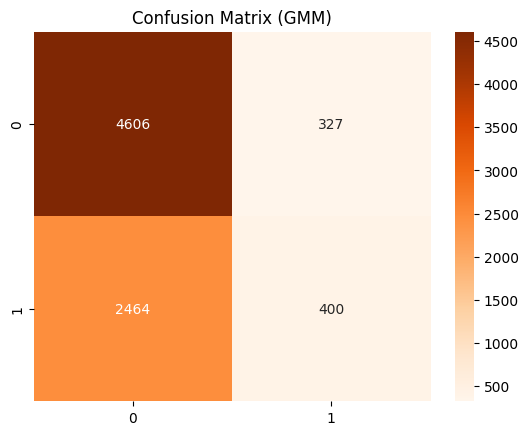

In [9]:
# To evaluate, we need to map the clusters based on the FULL training set
# Note: In a pure unsupervised setting, we might interpret clusters based on features.
# Here we are doing semi-supervised/adaption for classification.

# Predict on Validation Set (using the map derived from full training data labels)
# We treat X_val as a 'test' set here relative to the mapping process

y_pred_val, cluster_map = get_gmm_predictions(final_model, X_val_scaled, X_train_full_scaled, y_train_full)

print("Final GMM Evaluation (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")

cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (GMM)')
plt.show()

In [10]:
print("Final Interpretation:")
print(f"The GMM model uses {best_params['n_components']} components with '{best_params['covariance_type']}' covariance.")
print("Each component was assigned a class label based on the majority vote of the training data points belonging to it.")
print("This approach adapts the unsupervised GMM for the classification task.")

Final Interpretation:
The GMM model uses 11 components with 'tied' covariance.
Each component was assigned a class label based on the majority vote of the training data points belonging to it.
This approach adapts the unsupervised GMM for the classification task.
